# 1D Systematics treatment

## Imports

In [1]:
import torch 
import h5py
import os 
import sys

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(0, "/home/lai/nplm/src")
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history
from analysis_utils import compute_df, produce_bins, save_binning, load_binning

## Config

In [2]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
hep.style.use(hep.style.CMS)

## Constants

In [4]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 24
FIGSIZE   = (10, 8)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

# # Statistics                                                                                                                                                   
# N_REF      = 200000
# N_BKG      = 2000
# N_SIG      = 10       
# SIG_LOC    = 6.4
# SIG_STD    = 0.16
# # Samples weights N_D/N_R
# N_R        = N_REF
# N_D        = N_BKG

# Systematics
SIGMA_S = 0.2
SIGMA_N = 0.2
SCALE   = np.array([-2, -1, -0.5, 0, 0.5, 1, 2]) * SIGMA_S
NORM    = np.array([-2, -1, -0.5, 0, 0.5, 1, 2]) * SIGMA_N

# Training parameters
N_EPOCHS   = 200000
PATIENCE   = 5000

# Network parameters
N_INPUTS     = 1
N_OUTPUTS    = 1
ARCHITECTURE = [N_INPUTS, 4, N_OUTPUTS]
WCLIP        = 9
ACTIVATION   = torch.nn.Sigmoid()


PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## DATASETS

In [5]:
# poisson fluctuate the number of events in each sample
# datasets = {
#     "-2":   np.random.exponential(scale=1*np.exp(SCALE[0]), size=(N_REF, 1)),
#     "-1":   np.random.exponential(scale=1*np.exp(SCALE[1]), size=(N_REF, 1)),
#     "-0.5": np.random.exponential(scale=1*np.exp(SCALE[2]), size=(N_REF, 1)),
#     "0":    np.random.exponential(scale=1*np.exp(SCALE[3]), size=(N_REF, 1)),
#     "0.5":  np.random.exponential(scale=1*np.exp(SCALE[4]), size=(N_REF, 1)),
#     "1":    np.random.exponential(scale=1*np.exp(SCALE[5]), size=(N_REF, 1)),
#     "2":    np.random.exponential(scale=1*np.exp(SCALE[6]), size=(N_REF, 1)),
# }

In [6]:
def read_data_with_nu(data_path: str, nu: float) -> np.ndarray:
    """
    Read data from file .h5 
    """
    fname = "data_1dexpon_ref_nus_{nu}sigmas.h5"
    data_file= os.path.join(data_path, fname.format(nu=nu))
    with h5py.File(data_file, "r") as f:
        data = f["data"][:]
    
    return data

In [15]:
bins = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")

### Central value

In [8]:
ref     = read_data_with_nu(data_path=DATA_PATH, nu=0)
w_ref   = np.ones_like(ref)
n_ref   = ref.shape[0]
idx_ref = np.arange(n_ref)

### Nuisance variations

In [9]:
feature     = np.array([])
targets     = np.array([])
weights     = np.array([])
nuisance    = np.array([])
nu_list     = np.array([-2, -1, -0.5, 0.5, 1, 2])
nu_std      = np.std(nu_list)
nu_list_std = nu_list*1./nu_std

In [11]:
# for each value of the nuisance parameter:
for nu in nu_list:
    
    # find the index of the nuisance parameter in the list
    i = np.where(nu==nu_list)[0][0]
    
    # check if the nuisance parameter is 0.0 (should not be zero, but in case we catch this exception)
    if nu==0:
        muonpt_scale_str = '0.0'
    else:
        # save the scale of the nuisance parameter as a string
        muonpt_scale_str=str(nu)
        
    # get the corresponding standard deviation of the nuisance parameter     
    nu_std = nu_list_std[i]
    
    
    data = read_data_with_nu(data_path=DATA_PATH, nu=nu)
    w_data = np.ones_like(data)
            
    n_data   = data.shape[0]
    idx_data = np.arange(n_data)
    
    # shuffle the data and reference samples
    np.random.shuffle(idx_ref)
    np.random.shuffle(idx_data)
    
    # create a mask for the data and reference samples with the correct luminosity scaling
    mask_REF   = (idx_ref  < int(n_ref  * 0.20))
    mask_DATA  = (idx_data < int(n_data * 0.20))
    
    
    # features_nu is the concatenation of the reference and data samples along the 0th axis for one value of the nuisance parameter
    feature_nu = np.concatenate((ref[mask_REF], data[mask_DATA]), axis=0)
    
    # targets_nu is the concatenation of the reference and data targets along the 0th axis for one value of the nuisance parameter
    # zeros for the reference, central value, and ones for the data, shifted value of the nuisance parameter
    targets_nu = np.append(np.zeros(ref[mask_REF].shape[0]), np.ones(data[mask_DATA].shape[0]))
    
    # nuisance_nu is the nuisance parameter std replicated for the total number of samples (reference + data)
    nuisanc_nu = np.ones(feature_nu.shape[0])*nu_std
    
    # weights_nu is the concatenation of the reference and data weights along the 0th axis for one value of the nuisance parameter
    weights_nu = np.append(w_ref[mask_REF], w_data[mask_DATA])
    
    
    # if this is the first value of the nuisance parameter, set the feature, target, weight, year label, and nuisance parameter arrays to the values for this value of the nuisance parameter
    if feature.shape[0]==0:
        feature  = feature_nu
        targets  = targets_nu
        weights  = weights_nu
        nuisance = nuisanc_nu
        
    # otherwise, concatenate the feature, target, weight, year label, and nuisance parameter arrays with the values for this value of the nuisance parameter
    else:
        feature  = np.concatenate((feature,  feature_nu), axis=0)
        targets  = np.concatenate((targets,  targets_nu), axis=0)
        weights  = np.concatenate((weights,  weights_nu), axis=0)
        nuisance = np.concatenate((nuisance, nuisanc_nu), axis=0)

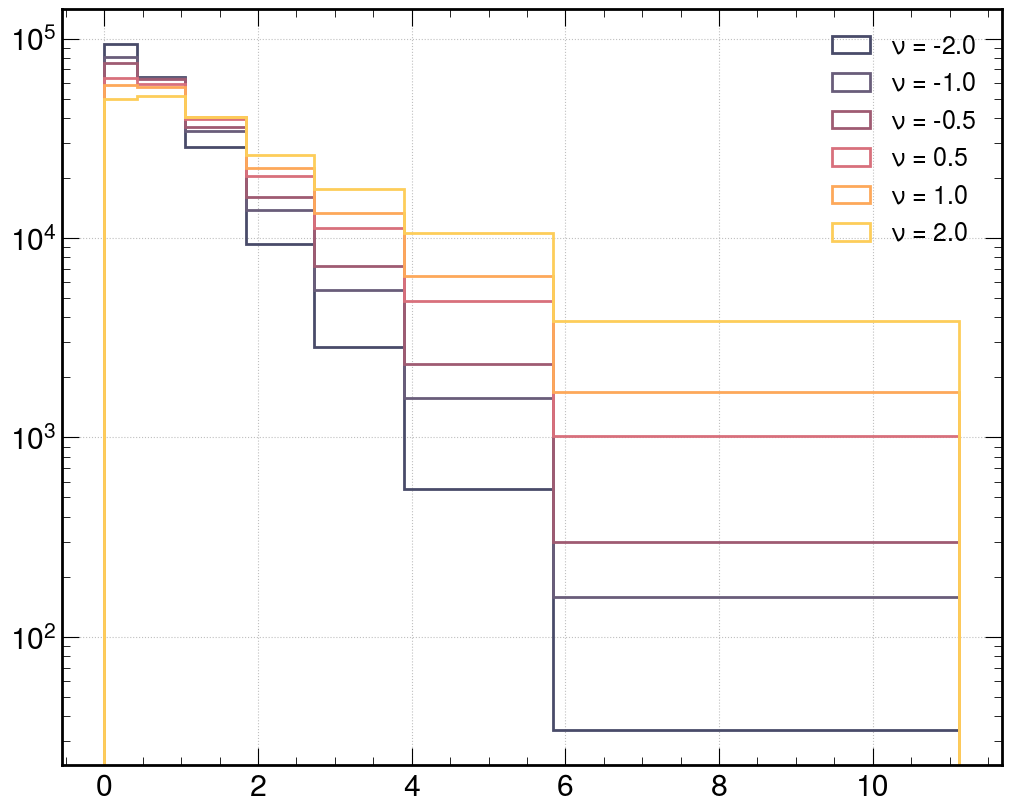

In [19]:
histo_nu_list = []

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
ax.grid(True, which='major', axis='both', alpha=0.5, color='gray')
ax.set_axisbelow(True)
# draw_cms_label(ax)

for nu_iter in range(len(nu_list)):
    
    nu     = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    lead_pt_nu    = feature[(nuisance==nu_std) & (targets==1)][:, 0]
    lead_pt_w_nu  = weights[(nuisance==nu_std) & (targets==1)]
    
    histo         = ax.hist(lead_pt_nu, bins=bins, weights=lead_pt_w_nu, histtype='step', lw=2, label=r'$\nu$ = %s'%(str(nu)), color=PALETTE_2[nu_iter])[0]
    
    histo_nu_list.append(histo)

# lead_pt_ref    = feature[(targets==0)][:, 0]
# lead_pt_w_ref  = weights[(targets==0)]*1./len(nu_list) # normalize the reference weights to the number of nuisance parameters

# histo_ref_0    = ax.hist(lead_pt_ref, bins=bins, weights=lead_pt_w_ref, histtype='step', lw=2, label=r'$\nu$ = %s'%(str(0)))[0]

ax.legend(fontsize=FONTSIZE-6, loc='upper right')

ax.set_yscale('log')

# ax.set_xlabel(xlabel_dict['leadmupt'], fontsize=FONTSIZE)
# ax.set_ylabel('Events', fontsize=FONTSIZE)
# ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# ax.set_xlim(bins[0] - (bins[1] - bins[0])/2, bins[-1] + (bins[-1] - bins[-2])/2)

# if PLOT:
#     fig.savefig(os.path.join(PLOT_FOLDER, 'leadmupt_nuisance.pdf'), bbox_inches='tight', dpi=300, facecolor='w')

plt.show()